<a href="https://colab.research.google.com/github/yeseul106/UROP_Software-Fault-Prediction/blob/main/Ternary_Classification_JM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as plt

In [19]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# 원본 csv 파일 읽어오기
JM1_original = pd.read_csv('/content/drive/MyDrive/UROP/UROP dataset/JM1_Nomalize_Severity1.csv', encoding='cp949')
print(JM1_original.shape)
JM1_original.head(5)

(10878, 22)


,LOC_BLANK,BRANCH_COUNT,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_COMPLEXITY,DESIGN_COMPLEXITY,ESSENTIAL_COMPLEXITY,LOC_EXECUTABLE,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,...,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,LOC_TOTAL,3level1
0,1.000000,1.000000,0.111111,0.456395,1.000000,0.957606,0.682927,1.000000,0.369055,0.919297,...,1.000000,0.00,1.000000,1.000000,1.000000,1.000000,0.593567,0.377129,1.000000,2
1,0.000000,0.254545,0.000000,0.000000,0.270789,0.256858,0.079268,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.327812,2
2,0.366890,0.586667,0.092593,0.168605,0.569296,0.543641,0.231707,0.562323,0.356243,0.510593,...,0.571970,0.00,0.297776,0.536129,0.572658,0.585240,0.396686,0.248175,0.529788,2
3,0.082774,0.033939,0.074074,0.122093,0.038380,0.044888,0.030488,0.047096,0.189793,0.110760,...,0.081152,0.02,0.007466,0.061963,0.097650,0.071956,0.117934,0.092457,0.064226,2
4,0.024609,0.489697,0.000000,0.049419,0.859275,0.002494,0.000000,0.288244,0.177612,0.492611,...,0.240848,0.00,0.138190,0.257888,0.269116,0.225092,0.790448,1.000000,0.244987,1


In [21]:
# 입력 데이터
input_data = JM1_original.iloc[:,:21]
print("input_data shape : ",input_data.shape)

input_data shape :  (10878, 21)


In [22]:
# 정답 레이블
y_label = JM1_original.iloc[:,21].to_numpy()
print("y_label shape : ",y_label.shape)

y_label shape :  (10878,)


In [23]:
class_group = JM1_original['3level1'].value_counts()
class_group

0    8776
1    1759
2     343
Name: 3level1, dtype: int64

# **데이터 살펴보기**

- 클래스 별 산점도를 그려봄으로써, 데이터의 분포를 알아본다.

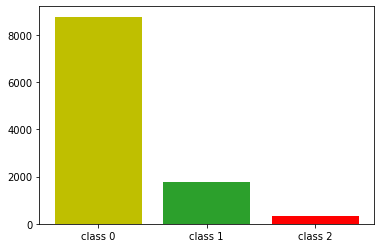

In [24]:
# 막대 그래프 그리기
import matplotlib.pyplot as plt

x = np.arange(3)
category = ['class 0', 'class 1', 'class 2']
colors = ['y', 'C2', 'r']

plt.bar(x, class_group, color=colors)
plt.xticks(x, category)

plt.show()

# **1) 이상치 데이터 제거 후 모델 학습/예측/평가**

- 21개의 feature 들 중에서 가장 상관계수가 높은 'LOC_TOTAL'에 대해서만 이상치를 찾아서 제거함.

- IQR을 이용해 이상치를 검출하는 함수를 생성한 뒤, 이를 이용해 검출된 이상치를 삭제한다.


In [25]:
def get_outlier(df=None, column=None, weight=1.5):
  #fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
  fraud = df[df['3level1']==0][column]
  quantile_25 = np.percentile(fraud.values,25)
  quantile_75 = np.percentile(fraud.values,75)

  #IQR을 구하고 IQR에 1.5를 곱해 최댓값과 최솟값 지점을 구함
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight

  #최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
  return outlier_index

In [26]:
outlier_index = get_outlier(df=JM1_original, column='LOC_TOTAL', weight=1.5)
print("이상치 데이터 인덱스:", outlier_index)

이상치 데이터 인덱스: Int64Index([   11,    54,    66,    80,   106,   113,   138,   143,   243,
              301,
            ...
            10832, 10833, 10834, 10835, 10847, 10848, 10850, 10851, 10852,
            10854],
           dtype='int64', length=779)


In [27]:
# 이상치 제거
JM1_original.drop(outlier_index, axis=0, inplace=True)
print(JM1_original.shape)

(10099, 22)


In [28]:
# 입력 데이터
input_data = JM1_original.iloc[:,:21]
print("input_data shape : ",input_data.shape)

input_data shape :  (10099, 21)


In [29]:
input_data = np.asarray(input_data,dtype=np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [30]:
# 정답 레이블
y_label = JM1_original.iloc[:,21].to_numpy()
print("y_label shape : ",y_label.shape)

y_label shape :  (10099,)


In [31]:
y_label[0]

2

In [32]:
cnt_true =0
cnt_false=0
# 정답 레이블 확인 해보기
for i in range(len(y_label)):
  if y_label[i]:
    cnt_true+=1
  else:
    cnt_false+=1

print("fault-prone: ", cnt_true)
print("non-fault-prone: ", cnt_false)

fault-prone:  2102
non-fault-prone:  7997


In [33]:
# 레이블 벡터화 
y_label = np.asarray(y_label).astype('float32')

In [34]:
y_label.shape

(10099,)

# **5-fold Cross Validation**

In [35]:
from sklearn.model_selection import StratifiedKFold
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# 5개의 파일로 쪼갬
n_fold = 5
seed = 0
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

#빈 metrics 배열 // confusion matrix를 구하기
fl_score_list = []
accuracy = []
loss = []
matrix = []
macro_auc_score_list = []
class2_auc_score = []

In [36]:
from typing import Pattern
# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='loss', patience=100)

In [ ]:
model = models.Sequential()
model.add(layers.Dense(32, input_shape = (21, )))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])
  
for train, test in skf.split(input_data, y_label):
  x_train, x_test = input_data[train], input_data[test]
  y_train, y_test = y_label[train], y_label[test]
  y_train = tf.keras.utils.to_categorical(y_train)
  y_test = tf.keras.utils.to_categorical(y_test)
  
  hist = model.fit(x_train, y_train, epochs=600, batch_size=32, verbose=1, callbacks=[early_stopping_callback])
  
  k_loss = "%.4f"%(model.evaluate(x_test, y_test)[0])
  k_accuracy = "%.4f"%(model.evaluate(x_test, y_test)[1])
  accuracy.append(k_accuracy)
  loss.append(k_loss)

  #예측 값 저장하기
  y_pred = model.predict(x_test)
  print(y_pred)

  auc_score = roc_auc_score(y_label[test], y_pred, multi_class='ovr', average = 'macro')
  print("auc_score: ", auc_score)
  macro_auc_score_list.append(auc_score)
  #auc_score.append(auc)

  # ROC & AUC
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # # Plot of a ROC curve for a specific class
  # plt.figure(figsize=(15, 5))
  # for idx, i in enumerate(range(3)):
  #     plt.subplot(131+idx)
  #     plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
  #     plt.plot([0, 1], [0, 1], 'k--')
  #     plt.xlim([0.0, 1.0])
  #     plt.ylim([0.0, 1.05])
  #     plt.xlabel('False Positive Rate')
  #     plt.ylabel('True Positive Rate')
  #     plt.title('Class %0.0f' % idx)
  #     plt.legend(loc="lower right")
  # plt.show()

  #roc_auc[2]가 클래스 2에 대한 auc
  class2_auc_score.append(roc_auc[2])
  
  y_pred_list = []
  #예측 값 shape 정리하기
  #3개의 클래스 확률 값 중 가장 큰 클래스로 바꾸기
  for i in range(len(y_pred)):
    list_tmp = y_pred[i].tolist()
    tmp = max(list_tmp)
    y_pred_list.append(list_tmp.index(tmp))

  from sklearn.metrics import plot_confusion_matrix
  from sklearn.metrics import f1_score
  print("y_pred_list.shape: ", len(y_pred_list))
  print("y_label.shape: ", y_label[test].shape)

  # #평가 매트릭 출력
  # plot_confusion_matrix(model,x_test,y_test, values_format='d', cmap='Blues')
  # plt.show()
  k_f1_score = f1_score(y_label[test], y_pred_list,  average = 'micro' )
  fl_score_list.append(k_f1_score)
  k_matrix = confusion_matrix(y_label[test], y_pred_list)
  matrix.append(k_matrix)

Epoch 1/600
253/253 [==============================] - 2s 5ms/step - loss: 0.6938 - categorical_accuracy: 0.7822
Epoch 2/600
253/253 [==============================] - 1s 5ms/step - loss: 0.5770 - categorical_accuracy: 0.7977
Epoch 3/600
253/253 [==============================] - 1s 4ms/step - loss: 0.5581 - categorical_accuracy: 0.8060
Epoch 4/600
253/253 [==============================] - 1s 5ms/step - loss: 0.5521 - categorical_accuracy: 0.8122
Epoch 5/600
253/253 [==============================] - 1s 4ms/step - loss: 0.5417 - categorical_accuracy: 0.8141
Epoch 6/600
253/253 [==============================] - 1s 5ms/step - loss: 0.5336 - categorical_accuracy: 0.8189
Epoch 7/600
253/253 [==============================] - 1s 5ms/step - loss: 0.5295 - categorical_accuracy: 0.8202
Epoch 8/600
253/253 [==============================] - 1s 4ms/step - loss: 0.5298 - categorical_accuracy: 0.8237
Epoch 9/600
253/253 [==============================] - 1s 5ms/step - loss: 0.5232 - categorical_

In [ ]:
print("\n %.f fold accuracy:" % n_fold, accuracy)
print("모든 fold의 평균 accuracy: ", (float(accuracy[0]) + float(accuracy[1]) + float(accuracy[2]) + float(accuracy[3]) + float(accuracy[4])) / 5)

print("\n %.f fold loss:" % n_fold, loss)
print("모든 fold의 평균 loss: ", (float(loss[0]) + float(loss[1]) + float(loss[2]) + float(loss[3]) + float(loss[4])) / 5)

print("\n %.f fold f1_score:" % n_fold, fl_score_list)
print("모든 fold의 평균 f1_score: ", (float(fl_score_list[0]) + float(fl_score_list[1]) + float(fl_score_list[2]) + float(fl_score_list[3]) + float(fl_score_list[4])) / 5)

print("\n %.f fold macro_auc_score:" % n_fold, macro_auc_score_list)
print("모든 fold의 평균 macro_auc_score: ", (float(macro_auc_score_list[0]) + float(macro_auc_score_list[1]) + float(macro_auc_score_list[2]) + float(macro_auc_score_list[3]) + float(macro_auc_score_list[4])) / 5)

print("\n %.f fold class2_auc_score:" % n_fold, class2_auc_score)
print("모든 fold의 평균 class2_auc_score: ", (float(class2_auc_score[0]) + float(class2_auc_score[1]) + float(class2_auc_score[2]) + float(class2_auc_score[3]) + float(class2_auc_score[4])) / 5)

# print("\n %.f fold confusion_matrix:" % n_fold, matrix)
print("\n===모든 fold의 평균 matrix=== \n", (matrix[0] + matrix[1] + matrix[2] + matrix[3] + matrix[4]) // 5)
